Paired TAM (transcient abnormal myleoproliferation) vs AML (acute myeloid leukemia) analysis of patients with the co-occuring condition of Down Syndrome using DESeq2 on IJC counts obtained from rMATS analysis.

Using a matrix constructed from Kids First Workflow V4 done on single runs, a series of scripts were created and are stored in this repository.  For each of the splicing types, all the runs considered for analysis are pooled and normalized to have a non-redundant set of splicing events.  A matrix is then constructed for each of the samples to be analyzed.  

Each splicing type has a bed file for visualizaiton in UCSC Genome browser of all the events, as well as created a matrix of the single runs normalized to the non-redundant union of files.  Both the source and the normalized bed file are available to ensure interprebility of results. 

Using associative arrays in an awk script, it was a rapid way to transform the individual counts from each of the individual runs into a matrix that facilitated analysis.

Using annotations obtained from the rMATS run that provided the coordinates of each of the splicing events as well as the gene that the junctions came from and the count of the reads that overlapped the junctions.   
 
Limma in this notebook is used to perform analysis of these junction counts provided by the rMATS routine.  Using these counts as junction expression.

Between the splicing event differences and the expression differences, between paired samples, biological functional differences may be obtained.

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")


Bioconductor version '3.18' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install



In [2]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'abind', 'bbmle', 'BH', 'BiocManager', 'bitops', 'bslib',
  'cachem', 'caTools', 'cli', 'coda', 'codetools', 'colorspace', 'cpp11',
  'crayon', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'digest', 'e1071',
  'edgeR', 'evaluate', 'farver', 'fastDummies', 'fastmap', 'fitdistrplus',
  'future', 'GenomeInfoDb', 'ggplot2', 'ggrepel', 'gtable', 'highr',
  'htmlwidgets', 'kernlab', 'KernSmooth', 'knitr', 'lifecycle', 'locfit',
  'matrixStats', 'munsell', 'mvtnorm', 'nlme', 'openssl', 'parallelly',
  'patchwork', 'pbdZMQ', 'plotly', 'polyclip', 'RANN', 'Rcpp', 'RcppArmadillo',
  'Rc

In [3]:
library(Glimma)
library(dplyr)
library(edgeR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma



In [4]:
setwd("/Users/annedeslattesmays/Scitechcon Dropbox/Anne DeslattesMays/projects/post-rmats-single-run/paired.TAM.AMLv2/SE_calculate")


In [5]:
getwd()


[1] "/Users/annedeslattesmays/Scitechcon Dropbox/Anne DeslattesMays/projects/post-rmats-single-run/paired.TAM.AMLv2/SE_calculate"

In [6]:
cts <- as.matrix(read.csv("SE.IJC.w.coordinates.matrix.csv",sep=",",row.names="ID"))

In [7]:
cts[1:3,11:dim(cts)[2]]

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,9,15,0,0,17,0,44,17,33,19
2,22,19,11,0,9,16,26,11,26,17
3,0,0,0,0,0,0,46,36,38,48


In [8]:
featureData <- data.frame(cts[,1:10])
featureData[1:3,]

,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSG00000117620.15,SLC35A3,chr1,+,100007033,100007156,99993536,99993741,100009287,100009323
2,ENSG00000117620.15,SLC35A3,chr1,+,100007033,100007156,99993536,99993741,100011364,100011533
3,ENSG00000117620.15,SLC35A3,chr1,+,100007033,100007156,99999260,99999415,100009287,100009323


In [9]:
featureData <- featureData[,c(1,2)]

In [10]:
head(featureData,2)

,GeneID,geneSymbol
,<chr>,<chr>
1,ENSG00000117620.15,SLC35A3
2,ENSG00000117620.15,SLC35A3


In [11]:
cts <- data.matrix(cts[,11:20])
mode(cts) <- "integer"
is.integer(cts)

[1] TRUE

In [12]:
dim(cts)
head(cts,2)

[1] 101298     10

,PAUVKY.03A,PAUVKY.40A,PAWHSD.03A,PAWHSD.40A,PAWSNZ.03A,PAWSNZ.40A,X_1_PAUTLA.03A,X_1_PAUTLA.40A,X_1_PAVUDU.03A,X_1_PAVUDU.40A
1,9,15,0,0,17,0,44,17,33,19
2,22,19,11,0,9,16,26,11,26,17


In [13]:
colnames(cts) <- c("PAUVKY.03A","PAUVKY.40A","PAWHSD.03A","PAWHSD.40A","PAWSNZ.03A","PAWSNZ.40A","PAUTLA.03A","PAUTLA.40A","PAVUDU.03A","PAVUDU.40A")

The PAWHSD samples are not TAM and AML but in fact TAM and TAM - the resulting heatmap when included showed they clustered together.  We will eliminate them from subsequent analyses.

In [14]:
cts <- cts[,-c(3,4)]

In [15]:
head(cts,2)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
1,9,15,17,0,44,17,33,19
2,22,19,9,16,26,11,26,17


In [16]:
# Condition 1: Rows with count > 1000 in columns 1, 3, 5, 7
TAM_rows_condition <- rowSums(cts[, c(1, 3, 5, 7)] > 1000) > 0
TAM_matrix<- cts[TAM_rows_condition, c(1, 3, 5, 7)]

# Condition 2: Rows with count > 1000 in columns 2, 4, 6, 8
AML_rows_condition <- rowSums(cts[, c(2, 4, 6, 8)] > 1000) > 0
AML_matrix <- cts[AML_rows_condition, c(2, 4, 6, 8)]

# Combine the sub-matrices by keeping rows that satisfy either condition 1 or condition 2
final_matrix <- cts[AML_rows_condition | TAM_rows_condition, ]

# View the dimensions of the resulting matrices
dim(TAM_matrix)
dim(AML_matrix)
dim(final_matrix)


[1] 2566    4

[1] 1421    4

[1] 2849    8

In [17]:
head(TAM_matrix)
head(AML_matrix)
head(final_matrix)

,PAUVKY.03A,PAWSNZ.03A,PAUTLA.03A,PAVUDU.03A
155,942,443,1061,827
276,416,0,238,1130
277,467,50,249,1136
280,398,0,226,1121
422,1111,931,1171,0
1245,523,432,1010,554


,PAUVKY.40A,PAWSNZ.40A,PAUTLA.40A,PAVUDU.40A
422,0,0,896,1313
495,0,455,623,1034
1002,689,174,312,1313
1396,460,0,0,2160
1397,320,0,0,1603
1805,0,0,1362,0


,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
155,942,494,443,136,1061,257,827,760
276,416,0,0,0,238,354,1130,0
277,467,292,50,21,249,442,1136,75
280,398,0,0,0,226,343,1121,35
422,1111,0,931,0,1171,896,0,1313
495,783,0,800,455,890,623,0,1034


In [18]:
cts <- final_matrix

featureData <- featureData[rownames(cts),]

In [19]:
dim(cts)
dim(featureData)

[1] 2849    8

[1] 2849    2

In [20]:
coldata <- read.csv("/Users/annedeslattesmays/Scitechcon Dropbox/Anne DeslattesMays/projects/post-rmats-single-run/design/design_paired_matrix.csv",row.names=1)

In [21]:
coldata


,patient,condition
,<chr>,<chr>
PAUVKY-03A,PAUVKY,preAML
PAUVKY-40A,PAUVKY,AML
PAWSNZ-03A,PAWSNZ,preAML
dPAWSNZ-40A,PAWSNZ,AML
PAUTLA-03A,PAUTLA,preAML
PAUTLA-40A,PAUTLA,AML
PAVUDU-03A,PAVUDU,preAML
PAVUDU-40A,PAVUDU,AML


In [22]:
coldata <- coldata[,c("patient","condition")]
coldata$condition <- factor(coldata$condition)
coldata$patient <- factor(coldata$patient)

In [23]:
rownames(coldata)

[1] "PAUVKY-03A"  "PAUVKY-40A"  "PAWSNZ-03A"  "dPAWSNZ-40A" "PAUTLA-03A" 
[6] "PAUTLA-40A"  "PAVUDU-03A"  "PAVUDU-40A"

In [24]:
rownames(coldata) <-sub("-",".",rownames(coldata))

In [25]:
colnames(cts)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [26]:
all(rownames(coldata) %in% colnames(cts))

[1] FALSE

In [27]:
dim(cts)
head(cts,4)
mode(cts) <- "integer"
is.integer(cts)

[1] 2849    8

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
155,942,494,443,136,1061,257,827,760
276,416,0,0,0,238,354,1130,0
277,467,292,50,21,249,442,1136,75
280,398,0,0,0,226,343,1121,35


[1] TRUE

In [28]:
# lets look at limma/voom
BiocManager::install("limma")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'limma'”
Old packages: 'abind', 'bbmle', 'BH', 'BiocManager', 'bitops', 'bslib',
  'cachem', 'caTools', 'cli', 'coda', 'codetools', 'colorspace', 'cpp11',
  'crayon', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'digest', 'e1071',
  'edgeR', 'evaluate', 'farver', 'fastDummies', 'fastmap', 'fitdistrplus',
  'future', 'GenomeInfoDb', 'ggplot2', 'ggrepel', 'gtable', 'highr',
  'htmlwidgets', 'kernlab', 'KernSmooth', 'knitr', 'lifecycle', 'locfit',
  'matrixStats', 'munsell', 'mvtnorm', 'nlme', 'openssl', 'parallelly',
  'patchwork', 'pbdZMQ', 'plotly', 'polyclip', 'RANN', 'Rcpp', 'RcppArmadillo',
  'Rc

In [29]:
BiocManager::install("statmod")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'statmod'”
Old packages: 'abind', 'bbmle', 'BH', 'BiocManager', 'bitops', 'bslib',
  'cachem', 'caTools', 'cli', 'coda', 'codetools', 'colorspace', 'cpp11',
  'crayon', 'crosstalk', 'curl', 'data.table', 'DESeq2', 'digest', 'e1071',
  'edgeR', 'evaluate', 'farver', 'fastDummies', 'fastmap', 'fitdistrplus',
  'future', 'GenomeInfoDb', 'ggplot2', 'ggrepel', 'gtable', 'highr',
  'htmlwidgets', 'kernlab', 'KernSmooth', 'knitr', 'lifecycle', 'locfit',
  'matrixStats', 'munsell', 'mvtnorm', 'nlme', 'openssl', 'parallelly',
  'patchwork', 'pbdZMQ', 'plotly', 'polyclip', 'RANN', 'Rcpp', 'RcppArmadillo',
  '

In [30]:
library(limma)
library(edgeR)
library(statmod)

In [31]:
# making a counts matrix
dge <- DGEList(counts=cts)

In [32]:
colnames(dge)

[1] "PAUVKY.03A" "PAUVKY.40A" "PAWSNZ.03A" "PAWSNZ.40A" "PAUTLA.03A"
[6] "PAUTLA.40A" "PAVUDU.03A" "PAVUDU.40A"

In [33]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
155        942        494        443        136       1061        257
276        416          0          0          0        238        354
    PAVUDU.03A PAVUDU.40A
155        827        760
276       1130          0

$samples
           group lib.size norm.factors
PAUVKY.03A     1  3201115            1
PAUVKY.40A     1  2239122            1
PAWSNZ.03A     1  4752512            1
PAWSNZ.40A     1  1493762            1
PAUTLA.03A     1  5992416            1
PAUTLA.40A     1  2358155            1
PAVUDU.03A     1  3896249            1
PAVUDU.40A     1  3698091            1

In [34]:
design <- model.matrix(~ 0 + factor(c(1,2,1,2,1,2,1,2)))
colnames(design) <- c("TAM","AML")

In [35]:
design

,TAM,AML
1,1,0
2,0,1
3,1,0
4,0,1
5,1,0
6,0,1
7,1,0
8,0,1


In [36]:
# normalize and filter
keep          <-filterByExpr(dge, design)

In [37]:
is.logical(keep)
sum(keep==TRUE)

[1] TRUE

[1] 1798

In [38]:
dge          <- dge         [keep,,keep.lib.size=FALSE]

In [39]:
# apply scale normalization
dge          <- calcNormFactors(dge)

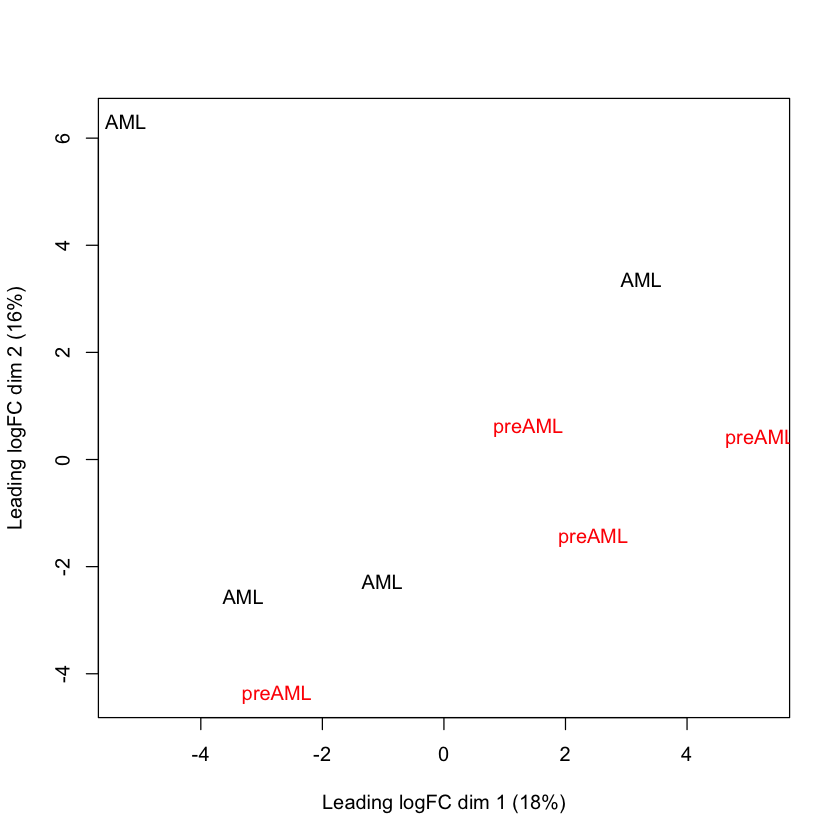

In [40]:
# MDS Plot - can we separate the samples well?
logCPM <- cpm(dge, log=TRUE, prior.count=3)
plotMDS(logCPM,labels=coldata$condition,top=10, col=c(rep(c("red","black"),3)))

In [41]:
head(logCPM)

,PAUVKY.03A,PAUVKY.40A,PAWSNZ.03A,PAWSNZ.40A,PAUTLA.03A,PAUTLA.40A,PAVUDU.03A,PAVUDU.40A
155,8.332355,7.77428280,7.02889435,6.64237902,7.976320,7.052974,7.88555048,7.83152711
276,7.159095,0.05886565,0.05886565,0.05886565,5.840418,7.511851,8.33420900,0.05886565
277,7.324785,7.02048099,3.96931562,4.02734680,5.904443,7.830507,8.34182447,4.54952174
280,7.095755,0.05886565,0.05886565,0.05886565,5.767171,7.466574,8.32270989,3.52152334
422,8.569706,0.05886565,8.09432423,0.05886565,8.118076,8.846611,0.05886565,8.61754139
495,8.066587,0.05886565,7.87644320,8.37405342,7.723919,8.323774,0.05886565,8.27394267


In [42]:
head(dge,2)

An object of class "DGEList"
$counts
    PAUVKY.03A PAUVKY.40A PAWSNZ.03A PAWSNZ.40A PAUTLA.03A PAUTLA.40A
155        942        494        443        136       1061        257
276        416          0          0          0        238        354
    PAVUDU.03A PAVUDU.40A
155        827        760
276       1130          0

$samples
           group lib.size norm.factors
PAUVKY.03A     1  2842343    1.0315502
PAUVKY.40A     1  2064072    1.0984498
PAWSNZ.03A     1  3947285    0.8663120
PAWSNZ.40A     1  1324481    1.0386977
PAUTLA.03A     1  4454947    0.9496429
PAUTLA.40A     1  2035114    0.9585329
PAVUDU.03A     1  3346656    1.0495993
PAVUDU.40A     1  3265154    1.0265379

In [43]:
fit <- lmFit(logCPM, design)
fit <- eBayes(fit, trend=TRUE)
de_results <- topTable(fit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 1798

[1] "CSDE1"  "PTMA"   "PTMA"   "HNRNPK" "ILF3"   "CCNI"

In [44]:
# There are too many values - lets reduce the size a bit more
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 5
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 1410    6

In [45]:
lookup <- rownames(significant_genes)
df <- as.data.frame(coldata[,c("condition","patient")])

significant_expression <- dge[lookup,]
dim(significant_expression)
length(lookup)

[1] 1410    8

[1] 1410

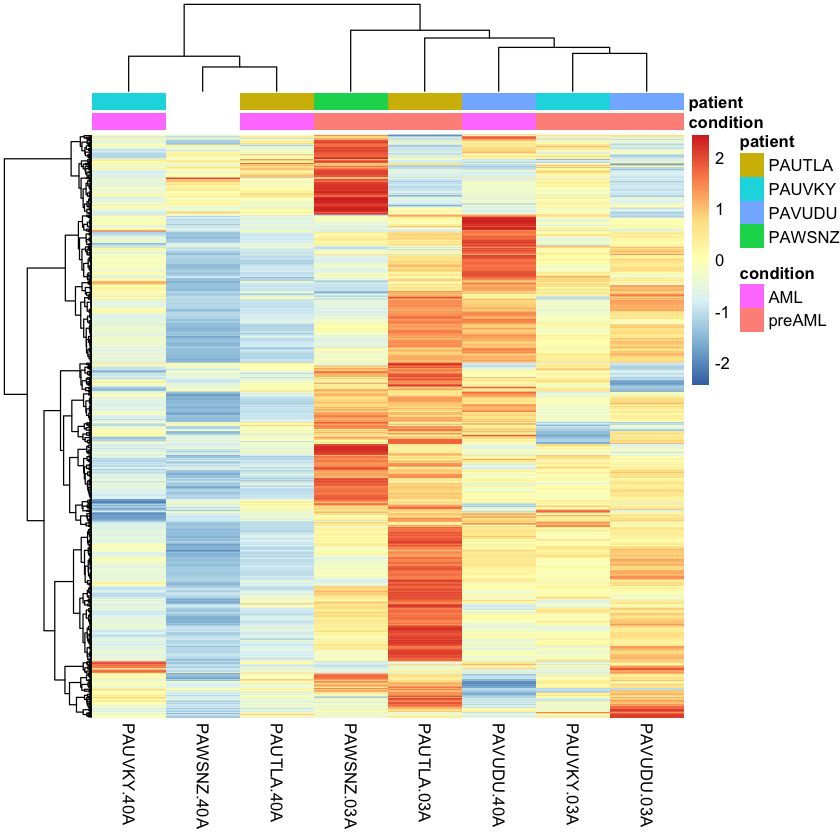

In [46]:
library("pheatmap")

significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

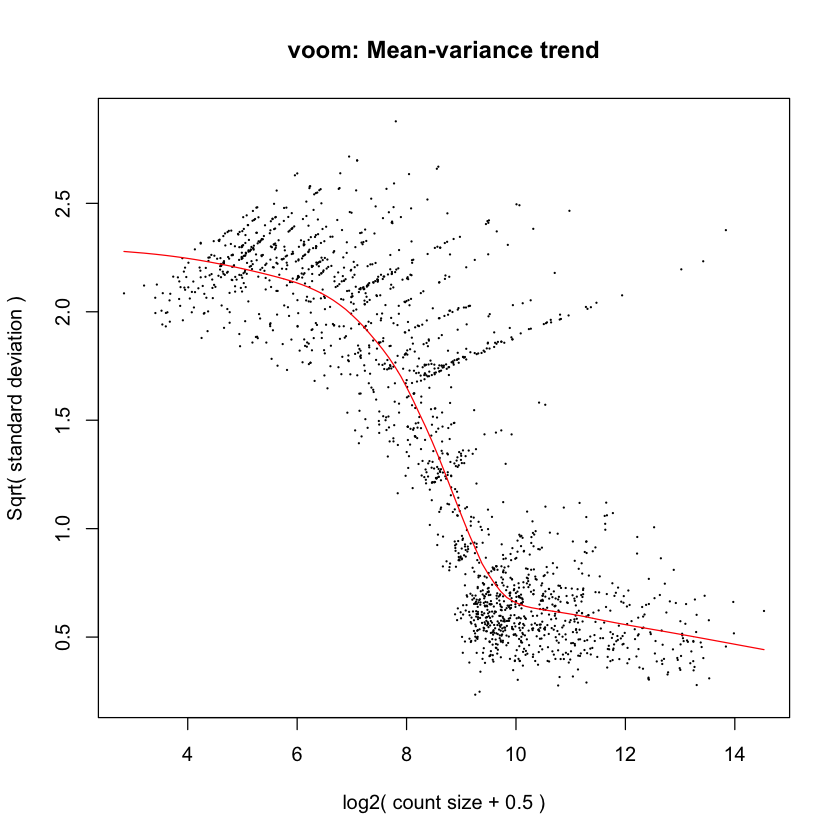

In [47]:
# weighting 
v <- voom(dge, plot=TRUE, normalize="quantile")

In [48]:
vfit <- lmFit(v, design)
vfit <- eBayes(vfit, trend=TRUE)
de_results <- topTable(vfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 1798

[1] "RPL4"  "RPL5"  "RPL3"  "RPL23" "RPS3A" "RPS2"

In [49]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 354   6

In [50]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

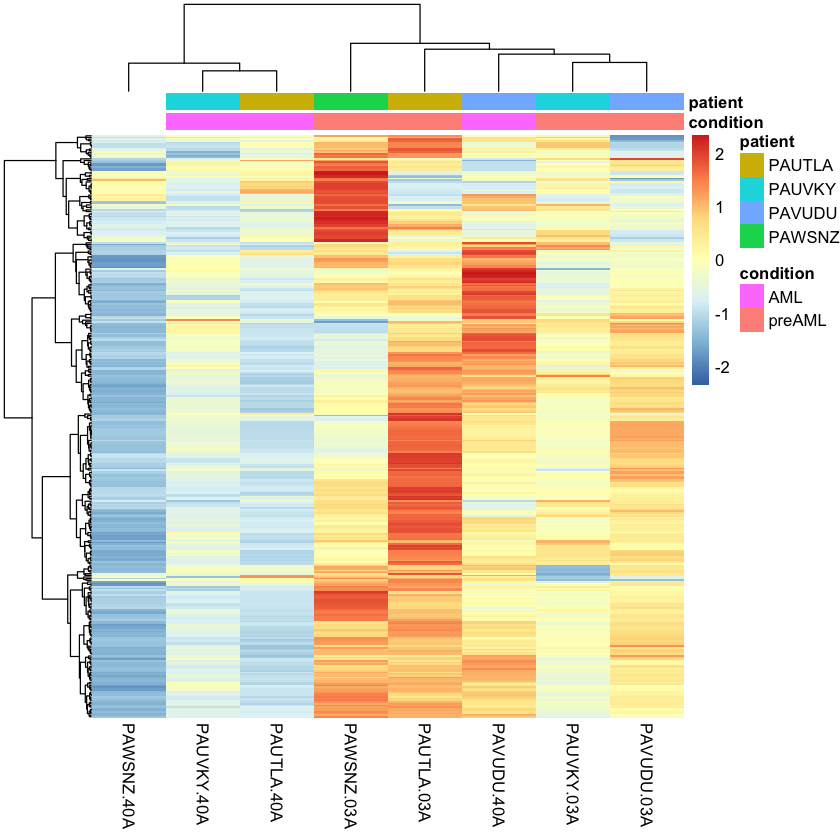

In [51]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [52]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPL4"  "RPL5"  "RPL3"  "RPL23" "RPS3A"

In [53]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 354

In [54]:
top_significant_genes <- dge[rownames(significant_genes),]

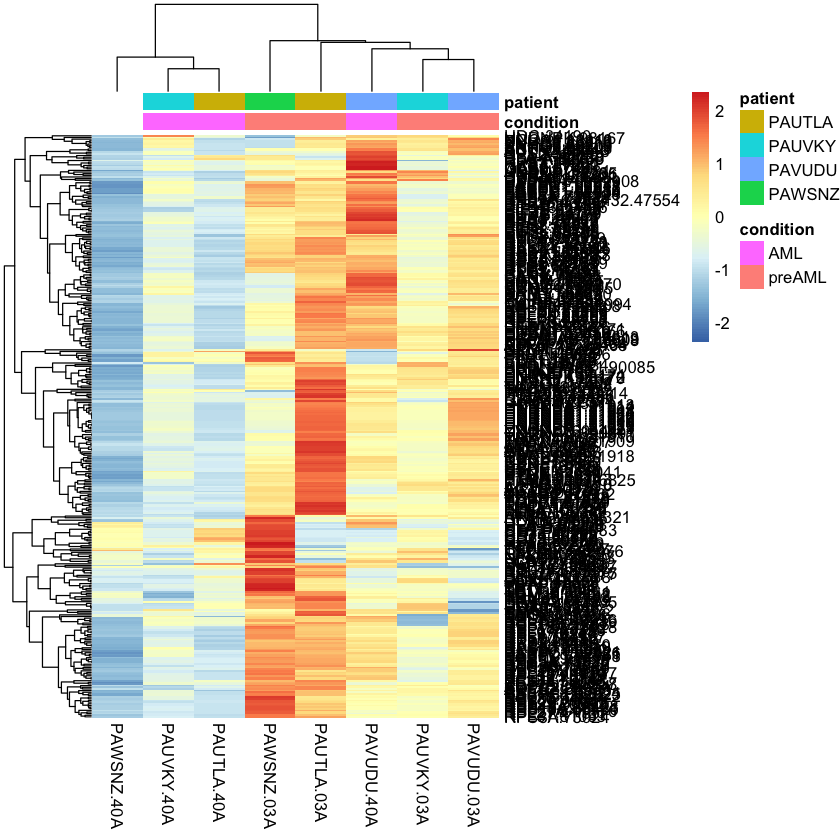

In [55]:
start=1
stop=length(top_gene_list)
date="2024Sept18_paired_TAM_AML_SE"
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)

In [56]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 354   2

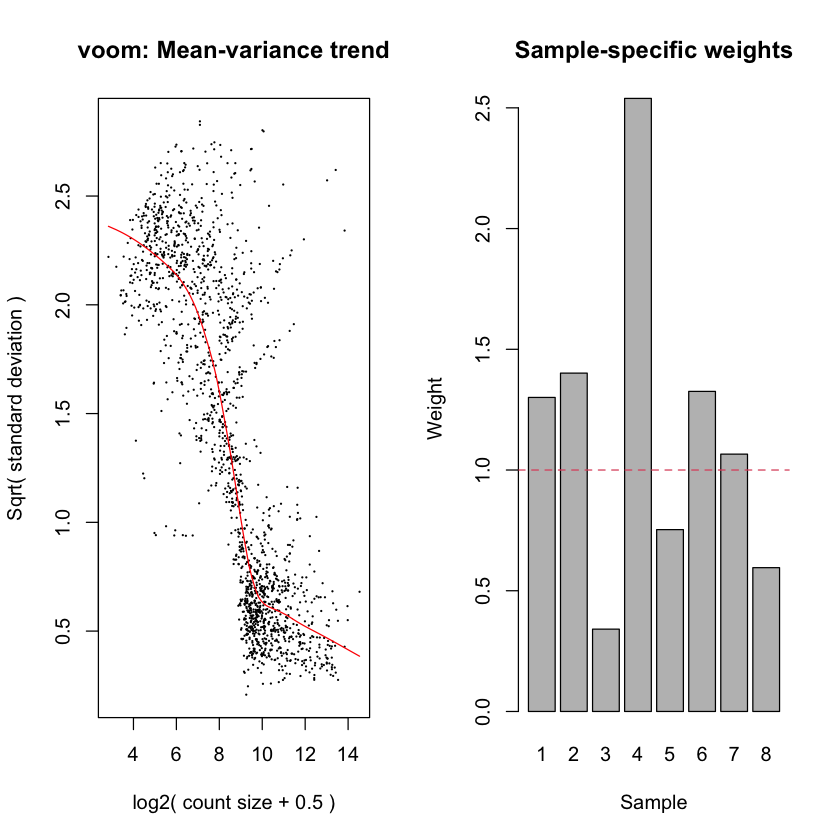

In [57]:
vwts <- voomWithQualityWeights(dge, design=design, normalize.method="quantile", plot=TRUE)

In [58]:
vwtsfit <- lmFit(vwts, design, weights = vwts$weights )
# no other weighting at this time.
 #* c(1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0))

In [59]:
vwtsfit <- eBayes(vwtsfit, trend=TRUE)
de_results <- topTable(vwtsfit, coef=ncol(design), n=Inf) 
lookup <- rownames(de_results)
length(featureData[lookup,2])
head(featureData[lookup,2])

[1] 1798

[1] "RPL5"   "RPL4"   "RPS3A"  "RPL3"   "RPL23"  "PABPC1"

In [60]:
# Assuming you have the 'de_results' object from topTable
fold_change_threshold <- 9
adjusted_pvalue_threshold <- 0.05

# Select genes that meet both fold change and adjusted p-value criteria
significant_genes <- de_results[
  abs(de_results$logFC) > fold_change_threshold &
  de_results$adj.P.Val < adjusted_pvalue_threshold,
]
dim(significant_genes)

[1] 346   6

In [61]:
lookup <- rownames(significant_genes)
significant_expression <- dge[lookup,]

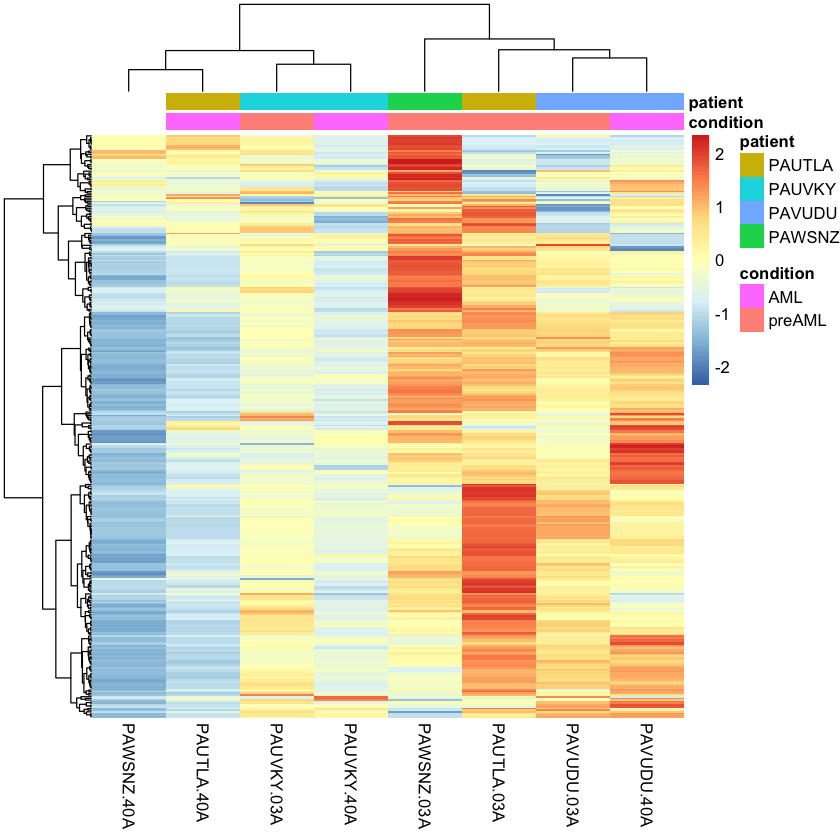

In [62]:
significant_out <- pheatmap(significant_expression, 
                            cluster_rows5=TRUE, 
                            show_rownames=FALSE,
                            cluster_cols=TRUE, 
                            annotation_col=df, 
                            scale="row",
                            clustering_method = "ward.D2",
                            clustering_distance_cols = "minkowski", 
                            clustering_distance_rows = "minkowski" )

In [63]:
featureData[head(rownames(significant_expression),5),2]

[1] "RPL5"  "RPL4"  "RPS3A" "RPL3"  "RPL23"

In [64]:
top_gene_list <- as.matrix(featureData[rownames(significant_expression),2])
length(top_gene_list)

[1] 346

In [65]:
top_significant_genes <- dge[rownames(significant_genes),]

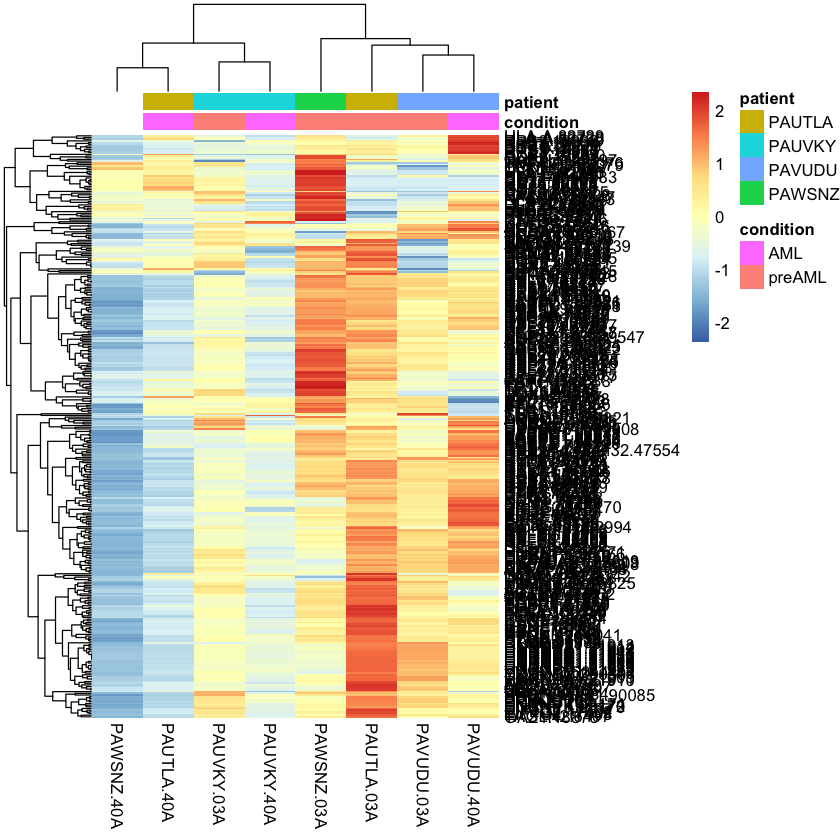

In [66]:
start=1
stop=length(top_gene_list)
piece <-top_significant_genes[significant_out$tree_row$order[start:stop],]
fd <- data.frame(featureData[rownames(piece),])
genejunction <- paste(featureData[rownames(piece),2],rownames(piece),sep=".")
rownames(fd) <- genejunction
rownames(piece) <- genejunction
outpiece<-pheatmap(piece, cluster_rows5=TRUE, show_rownames=TRUE,
         cluster_cols=TRUE, annotation_col=df, scale="row",clustering_distance_cols = "minkowski", clustering_distance_rows = "minkowski" )
piece_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")

# Order by TAM elements, followed by AML elements
piece_exp <- piece[,c(1,3,5,7,2,4,6,8)]
colnames(piece_exp) <- colnames(piece[,c(1,3,5,7,2,4,6,8)])
rownames(piece_exp) <- rownames(piece)
string_filename <- paste(paste(paste(paste(date,"string_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
piece_exp_filename <- paste(paste(paste(paste(date,"expression_top_gene_list",sep="_"),start,sep="_"),stop,sep="_"),"csv",sep=".")
write.csv(piece_exp$counts,piece_exp_filename,quote=FALSE)
write.csv(rownames(piece),piece_filename,quote=FALSE,row.names=FALSE)
write.csv(fd[,2],string_filename,quote=FALSE,row.names=FALSE)
violin_plot_filename=piece_exp_filename

In [67]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
outfile <- paste(date,"vwts_top_gene_list_heatmap.pdf",sep="_")
outfile
save_pheatmap_pdf(outpiece, outfile)

[1] "2024Sept18_paired_TAM_AML_SE_vwts_top_gene_list_heatmap.pdf"

pdf 
  2

In [68]:
#If you want something like gene-to-cluster assignment, you can 'cut' your row dendrogram into a pre-selected number of groups as follows:
# -- inspecating above the rows seem to fall into 7 groups
clusters<- as.matrix(row_clusters<- sort(cutree(significant_out$tree_row, k=7)),nrows=dim(top_genes_expression)[1],ncols=1)
genes_in_clusters = featureData[rownames(clusters),2]
genes_in_clusters.df <- data.frame(featureData[rownames(clusters),2], clusters)
colnames(genes_in_clusters.df) <- c("geneSymbol","cluster")
dim(genes_in_clusters.df)
cluster_1_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 1,]
cluster_2_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 2,]
cluster_3_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 3,]
cluster_4_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 4,]
cluster_5_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 5,]
cluster_6_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 6,]
cluster_7_genes <- genes_in_clusters.df[genes_in_clusters.df$cluster == 7,]

cluster_1_filename <- paste(paste(date, "cluster_1", sep="_"),"csv",sep=".")
cluster_2_filename <- paste(paste(date, "cluster_2", sep="_"),"csv",sep=".")
cluster_3_filename <- paste(paste(date, "cluster_3", sep="_"),"csv",sep=".")
cluster_4_filename <- paste(paste(date, "cluster_4", sep="_"),"csv",sep=".")
cluster_5_filename <- paste(paste(date, "cluster_5", sep="_"),"csv",sep=".")
cluster_6_filename <- paste(paste(date, "cluster_6", sep="_"),"csv",sep=".")
cluster_7_filename <- paste(paste(date, "cluster_7", sep="_"),"csv",sep=".")

write.csv(cluster_1_genes$geneSymbol,cluster_1_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_2_genes$geneSymbol,cluster_2_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_3_genes$geneSymbol,cluster_3_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_4_genes$geneSymbol,cluster_4_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_5_genes$geneSymbol,cluster_5_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_6_genes$geneSymbol,cluster_6_filename,quote=FALSE,row.names=FALSE)
write.csv(cluster_7_genes$geneSymbol,cluster_7_filename,quote=FALSE,row.names=FALSE)


[1] 346   2